# Opteeq Compter Vision Project - Task B - Image Standardisation Testing Notebook

During image standardisation we need to perform several operations to prepare images for annotation using the GCloud Vision API. This includes orienting the image correctly, ensuring that images have a minimum size and that the ratio of the images is suitable. 

Google Vision API reccommends 1067 x 768 image size for document text detection as OCR requires more resolution to detect characters.

Image resize code: 


Image angle detection code: 
https://stackoverflow.com/questions/58010660/detect-image-orientation-angle-based-on-text-direction/58020893

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Helper functions
def multi_img_plot(imgs): 

    fig = plt.figure(figsize=(9, 13))
    
    columns = 4
    rows = 5
    
    for i in range(1,len(imgs)):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()
    
def get_img_paths_local():

    img_paths = []
    
    paths = os.listdir(os.path.abspath('data'))
    
    for i, path in enumerate(paths):
        if path.endswith('.jpg'):
            img_paths.append(path)
            
    return img_paths

def img_processing_test(img_paths): 

    processed_imgs = []
    
    for i, path in enumerate(img_paths):
        im_path = os.path.abspath('data/' + path)
        img = cv2.imread(im_path)
        rotated_img = rotate_image(img)
        resized_img = image_resize(rotated_img)
        processed_imgs.append(resized_img)

    return processed_imgs

# Image resizing - min size with same aspect ratio

In [4]:
import cv2
import numpy as np

def image_resize(img: 'numpy:ndarray', width: int = None, height: int = None, inter = cv2.INTER_AREA) -> 'numpy.ndarray':
    """
    Resize an image keeping the same aspect ratio. 
    :param img: Image array
    :param width: Desired image width
    :param height: Desired image height
    :param inter: OpenCV interpolation function
    :return: Resized image array
    """
    
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = img.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return img

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized_img = cv2.resize(img, dim, interpolation = inter)

    # return the resized image
    return resized_img


def check_image_size(img: 'numpy.ndarray') -> 'numpy.ndarray': 
    """
    Check image size and call image resize function using either height or width if either dimension
    smaller than 1067x768 and call resize_image function using the parameter that is too small as the input. 
    :param img: Image array
    :return: None
    """
    # Height and width reccommended by GCloud Vision API 
    height = 1067
    width = 768
    
    # Get image height and width
    (h, w) = img.shape[:2]
    
    # Resize image if needed and return resized or original image 
    if h < height and w < width:
        print("Image height and width too small, resizing image...")
        return image_resize(img, height=1067)
    elif h < height and w >= width: 
        print("Image height too small, image width ok, resizing image...")
        return image_resize(img, height=1067)
    elif h >= height and w < width:
        print("Image height ok, image width too small, resizing image...")
        return image_resize(img, width=768)
    else: 
        return img
    



# Region of interest detection/cropping 

In [5]:
# Testing of image processing functions
img_paths = get_img_paths_local()

original_imgs = []

for i, path in enumerate(img_paths):
    im_path = os.path.abspath('data/' + path)
    img = cv2.imread(im_path)
    original_imgs.append(img)

multi_img_plot(original_imgs)

NameError: name 'plt' is not defined

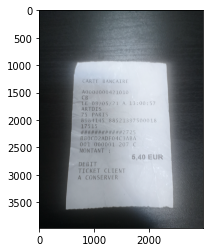

In [300]:
img = original_imgs[0]
plt.imshow(img)

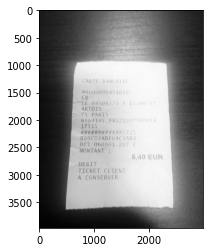

In [301]:
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray, (17, 17), 0)
plt.imshow(blur, cmap='Greys_r')

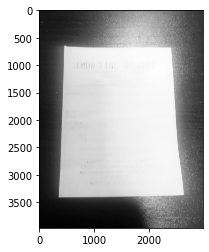

In [302]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
dilated = cv2.dilate(blurred, rectKernel)
plt.imshow(dilated, cmap='Greys_r')

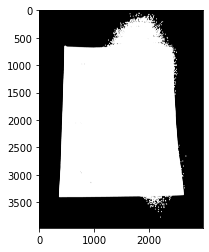

In [303]:
# Define lower and uppper limits
lower = 140
upper = 255

# Create mask to only select black
thresh = cv2.inRange(dilated, lower, upper)
plt.imshow(thresh, cmap='Greys_r')

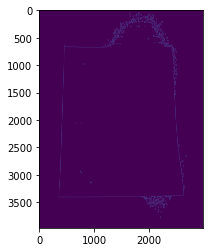

In [276]:
edged = cv2.Canny(thresh, 100, 200, apertureSize=7)
plt.imshow(edged)

# Orientation correction - Pixel method

In [1]:
def detect_angle(img: 'numpy.ndarray') -> int:
    """
    Text orientation detection.  
    :param img: Image array
    :return: angle corresponding to orientation, 90=desired orientation
    """
    # Convert image to grayscale and perform a gaussian blur 
    # Then use adaptive threshhold to obtain a binary image
    mask = np.zeros(img.shape, dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    adaptive = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,15,4)
    
    
    # Find contours
    cnts = cv2.findContours(adaptive, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Filter using contour area to remove noise particles and large borders
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 45000 and area > 20:
            cv2.drawContours(mask, [c], -1, (255,255,255), -1)
    
    # Pass contours that pass the filter onto a mask 
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    h, w = mask.shape
    
    # To determine the angle we split the image in half based the dimensions
    # If width > height then it must be a horizontal image so we split in half vertically
    # If height > width then it must be a vertical image so we split in half horizontally
 
    # Horizontal
    if w > h:
        left = mask[0:h, 0:0+w//2]
        right = mask[0:h, w//2:]
        left_pixels = cv2.countNonZero(left)
        right_pixels = cv2.countNonZero(right)
        return 0 if left_pixels >= right_pixels else 270 # Changed 180 to 270
    
    # Vertical
    else:
        top = mask[0:h//2, 0:w]
        bottom = mask[h//2:, 0:w]
        top_pixels = cv2.countNonZero(top)
        bottom_pixels = cv2.countNonZero(bottom)
        return 90 if bottom_pixels >= top_pixels else 180 # Changed 270 to 180
    
def rotate_image(img: 'numpy:ndarray') -> 'numpy.ndarray': 
    """
    Image rotation function using output of detect_angle().
    :param img: Image array
    :return: Rotated image array
    """
    # Get image angle using angle detection function 
    img_angle = detect_angle(img)
    
    # Rotate image to 90 degrees (Portrait)
    if img_angle == 90:
        return img
    elif img_angle == 0: 
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif img_angle == 270:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif img_angle == 180:
        return cv2.rotate(img, cv2.ROTATE_180)

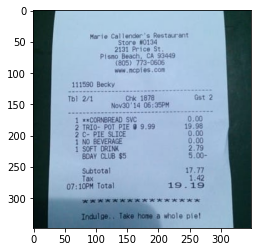

In [6]:
im_path = os.path.abspath('data/test_images/1193-receipt.jpg')

img = cv2.imread(im_path)

plt.imshow(img)

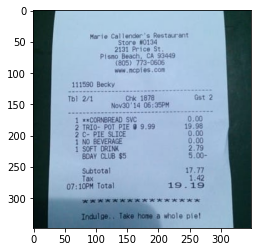

In [7]:
rotated_img = rotate_image(img)
plt.imshow(rotated_img)